## Modeling House Prices using Regularization methods --> ElastiNetCV & XGBoost

In this kernel, we will attempt to perform the below:
* Look at the data
* Perform some EDA
* Feature Engineering
* Model evaluation
* Regularization

In this particular kernel, the main target is to implement the **ElastinetCv** and **XGBoost** regularization techniques for best fit model selection.

In [31]:
# Importing all the necessary libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import norm, skew
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from xgboost import XGBRegressor, plot_importance

import os
print(os.listdir("../input"))

['test.csv', 'train.csv', 'sample_submission.csv', 'data_description.txt']


In [32]:
#Reading the data
data = pd.read_csv('../input/train.csv')
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [33]:
#Checking for null values (in % terms)
(data.isnull().sum()/ len(data)).sort_values(ascending = False)[: 10]

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
dtype: float64

There are 4 main features that have 80% & above null values. These we can delete. We can also delete the 'Id' column.

In [34]:
data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Id'], axis = 1, inplace = True)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


## Exploratory Data Analysis

Looking at the Target Feature Distribution and Relation with other variables


 µ = 180921.20 and E = 79415.29


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519414, 180921.19589041095, 0.9319665641512983))

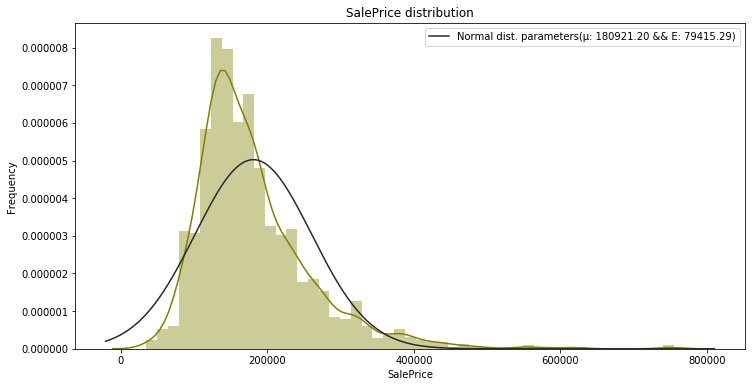

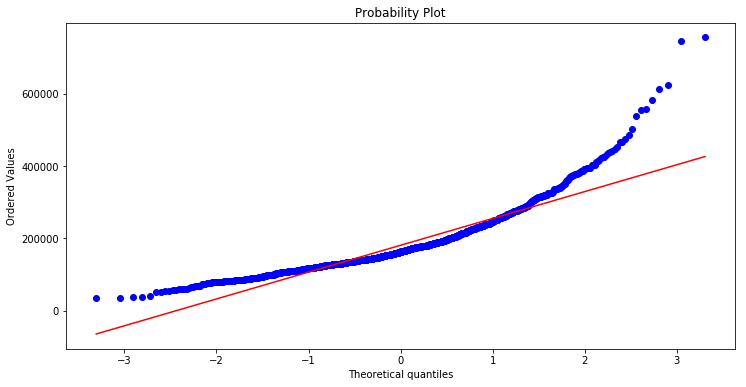

In [35]:
#Checking the distribution of the target feature 'SalePrice'
plt.figure(figsize = (12, 6))
sns.distplot(data['SalePrice'], fit = norm, color = 'olive')

#Obtaining the parameters for fitting the 'norm' curve
(µ, E) = norm.fit(data['SalePrice'])
print('\n µ = {:.2f} and E = {:.2f}'.format(µ, E))

plt.ylabel('Frequency')
plt.legend(['Normal dist. parameters(µ: {:.2f} && E: {:.2f})'.format(µ, E)], loc = 'best')
plt.title('SalePrice distribution')

#Obtaning the probaility plot
plt.figure(figsize = (12, 6))
stats.probplot(data['SalePrice'], plot = plt)

The graph above indicates right skewness in the 'SalePrice' feature. We will need to perform log transformation to rectify the skewness.

µ = 12.02 and E = 0.40


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.398259646654151, 12.024057394918403, 0.9953761551826702))

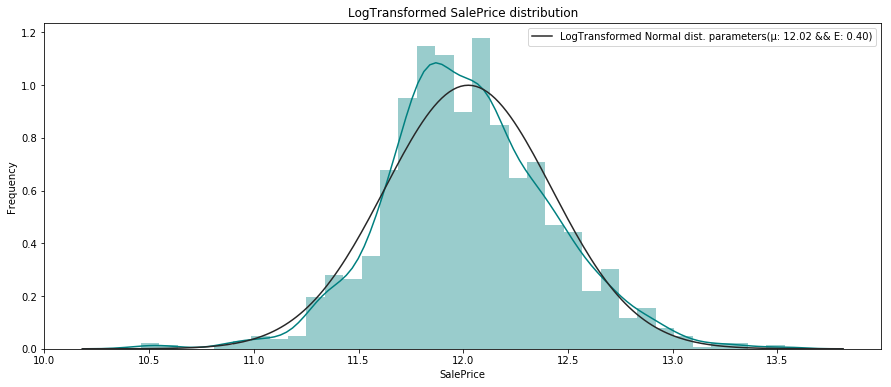

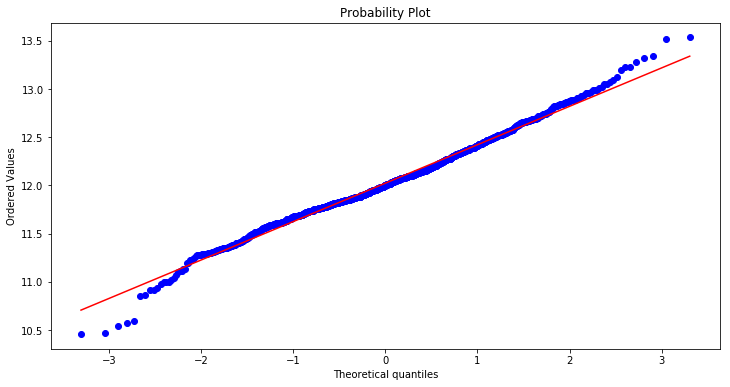

In [36]:
plt.figure(figsize = (15, 6))
sns.distplot(np.log1p(data['SalePrice']), fit = norm, color = 'teal')

#Obtaining the parameters for fitting the 'norm' curve
(µ, E) = norm.fit(np.log1p(data['SalePrice']))
print('µ = {:.2f} and E = {:.2f}'.format(µ, E))

plt.ylabel('Frequency')
plt.legend(['LogTransformed Normal dist. parameters(µ: {:.2f} && E: {:.2f})'.format(µ, E)], loc = 'best')
plt.title('LogTransformed SalePrice distribution')

#Obtaining the LogTransformed SalePrice probplot
plt.figure(figsize = (12, 6))
stats.probplot(np.log1p(data['SalePrice']), plot = plt)

Let us now look at our data to see how the values range.

In [37]:
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Let us check the correlation between the different features before we encode the Categorical Features. This is in order to keep our features count low, as encoding will shoot up the number of columns(features).

Text(0.5, 0.98, 'Pearson Correlation Heatmap')

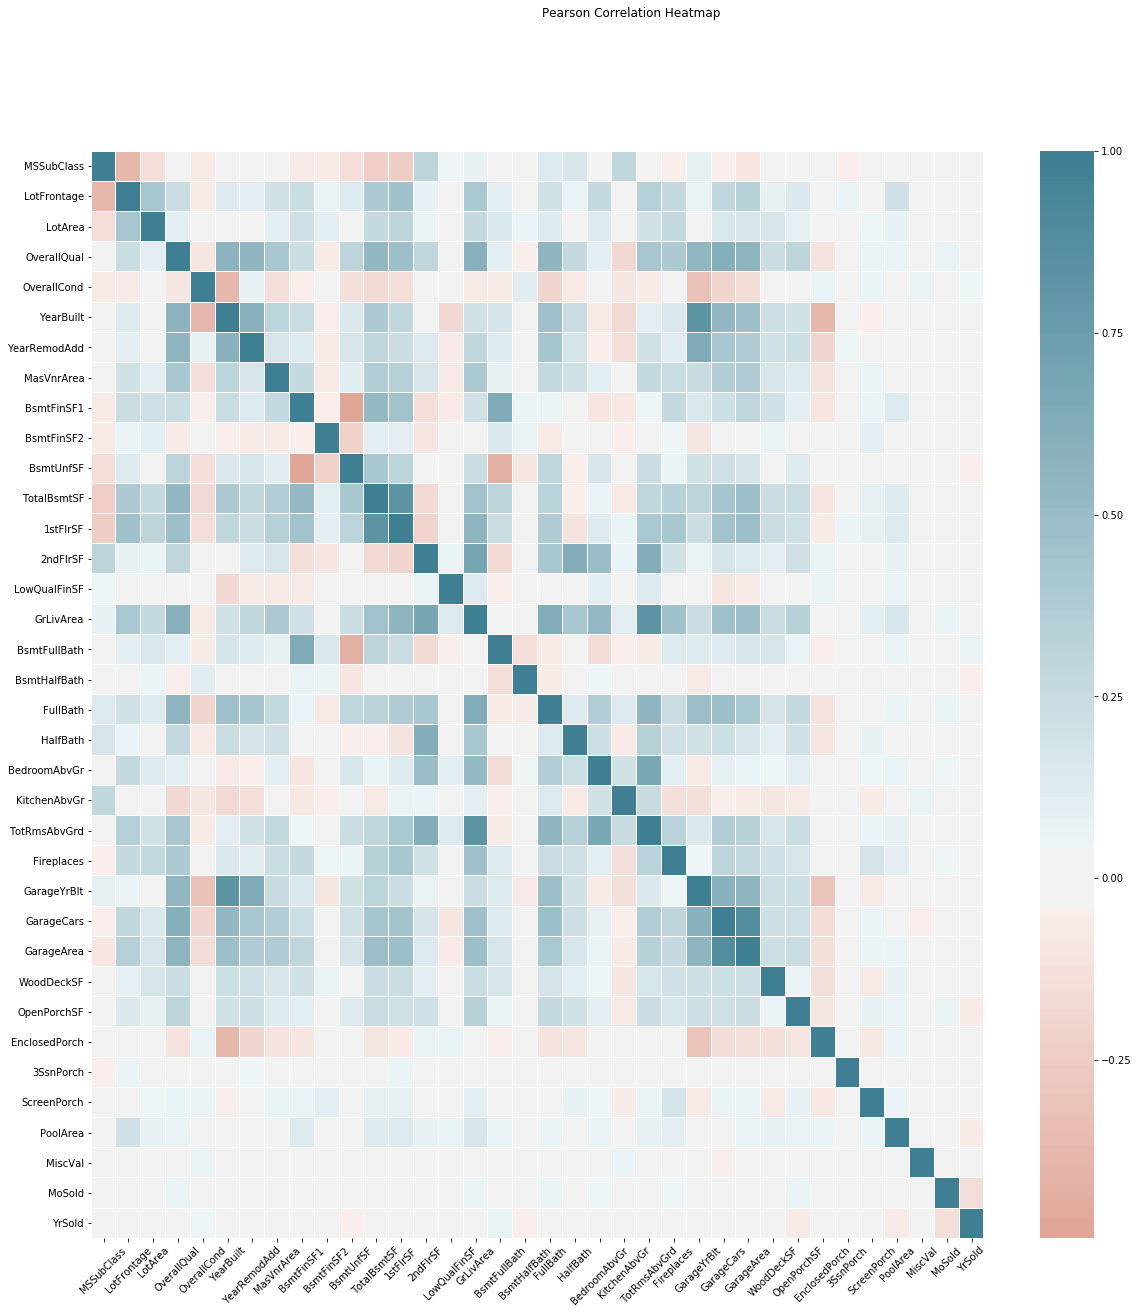

In [38]:
corr = data.drop(['SalePrice'], axis = 1).corr()
plt.figure(figsize = (20, 20))
ax = sns.heatmap(corr, linewidths = 0.01, center = 0, cmap = sns.diverging_palette(20, 220, n = 200))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.suptitle('Pearson Correlation Heatmap')

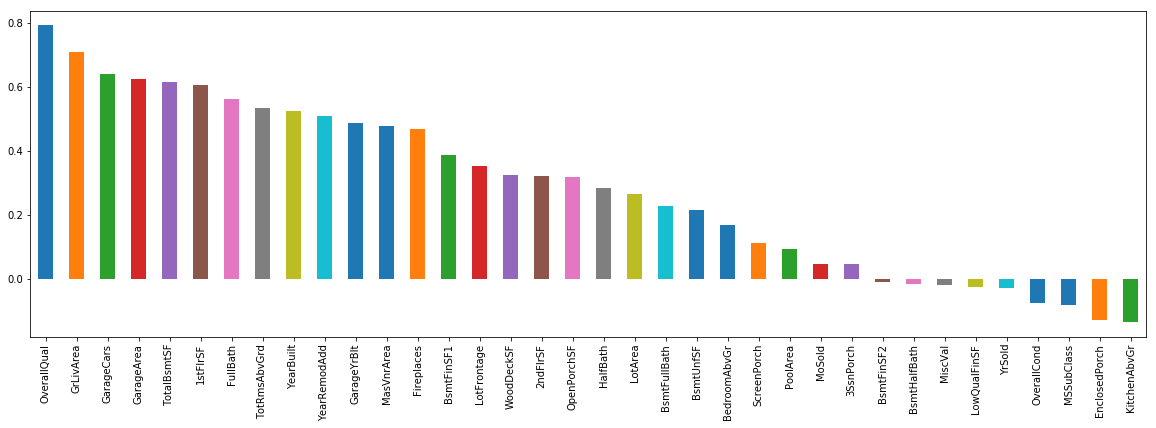

In [39]:
#Checking the correlation of 'SalePrice' with other features
corr_SP = data.corr()['SalePrice'].sort_values(ascending = False)
#corr_SP = corr_SP.filter(lambda x: x > 0.6 or x < -0.6)
plt.figure(figsize = (20, 6))
corr_SP.drop('SalePrice').plot.bar()

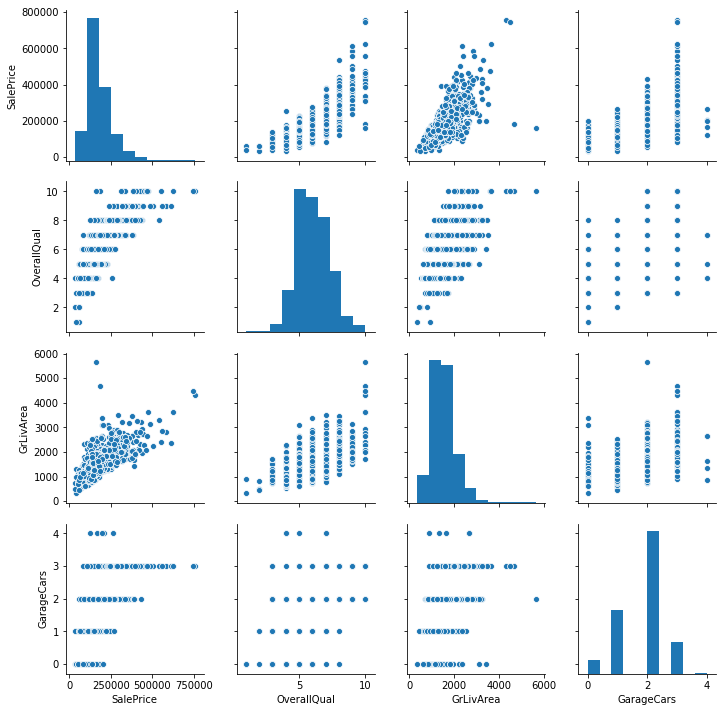

In [40]:
sns.pairplot(data[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars']])

## Feature Engineering

* Fill up null values(with the mean)
* Log Transformation of Skewed data
* Encoding of categorical features
* Split the data for training & testing

In [41]:
#Log Transformation of skewed data
data['SalePrice'] = np.log1p(data['SalePrice'])
num_feats = data.dtypes[data.dtypes != 'object'].index

#Computing skewness and performing log transformation
skew_feats = data[num_feats].apply(lambda x: skew(x.dropna())) #computing skewness after removing null values, if any
skew_feats = skew_feats[skew_feats > 0.75] #selecting those numeric features that have a skewness > 0.75
skew_feats = skew_feats.index 
data[skew_feats] = np.log1p(data[skew_feats])

#Encoding of Categorical Features
data = pd.get_dummies(data)

#Filling up NaN values with the mean
data = data.fillna(data.mean())

#Data Standardization
#ss = StandardScaler()
#data = ss.fit_transform(data)

#Converting back to DataFrame
data = pd.DataFrame(data)
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,...,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,0.0,7.444833,1,0.000000,2,1,3,0.693147,8,0,2003.0,2,548,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,2,2008,12.247699,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,0.0,7.141245,0,0.693147,2,0,3,0.693147,6,1,1976.0,2,460,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007,12.109016,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,0.0,7.488294,1,0.000000,2,1,3,0.693147,6,1,2001.0,2,608,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,9,2008,12.317171,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,0.0,7.448916,1,0.000000,1,0,3,0.693147,7,1,1998.0,3,642,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,2,2006,11.849405,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,0.0,7.695758,1,0.000000,2,1,4,0.693147,9,1,2000.0,3,836,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,12,2008,12.429220,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [42]:
#Splitting the data into training and test set
X, Y = data.drop(['SalePrice'], axis = 1), data['SalePrice']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, random_state = 0)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## ElastiNetCV

* ElasticNet is a hybrid between Lasso(L1) and Ridge(L2) regularization methods.
* ElasticNet works best when there are a number of correlated features.
* ElasticNetCV can be used to set the parameters Alpha(α) and l1_ratio(ρ) by using cross_validation.

In [43]:
cv_model = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1], eps = 1e-3, n_alphas = 100, fit_intercept = True,
                      normalize = True, precompute = 'auto', max_iter = 2000, tol = 0.0001, cv = 6,
                      copy_X = True, verbose = 0, n_jobs = -1, positive = 'False', random_state = 0)
cv_model.fit(X_train, Y_train)
print('Optimal Alpha(α): %.8f' %cv_model.alpha_)
print('Optimal l1_ratio(ρ): %.3f' %cv_model.l1_ratio_)
print('Number of iterations %d' %cv_model.n_iter_)

Optimal Alpha(α): 0.00015032
Optimal l1_ratio(ρ): 0.900
Number of iterations 63


0 > Optimal l1_ratio(ρ): 0.900 < 1
* Indicates that the penalty is a combination of L1 and L2 noise.

## Model Valuation

In [44]:
Y_train_pred = cv_model.predict(X_train)
Y_test_pred = cv_model.predict(X_test)

print('Train r2 score:', r2_score(Y_train_pred, Y_train))
print('Test r2 score:', r2_score(Y_test_pred, Y_test))

train_mse = mean_squared_error(Y_train_pred, Y_train)
test_mse = mean_squared_error(Y_test_pred, Y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print('Train RMSE is: %.4f' %train_rmse)
print('Test RMSE is: %.4f' %test_rmse)

#The RMSE here is actually RMSLE ( Root Mean Squared Logarithmic Error). Because we have taken the log of the actual values. 

Train r2 score: 0.9123466040256557
Test r2 score: 0.8574687620137692
Train RMSE is: 0.1108
Test RMSE is: 0.1466


## Undertanding Feature Importance

Total important features: (275,)
Selected features: 66, reduction of 76.00%


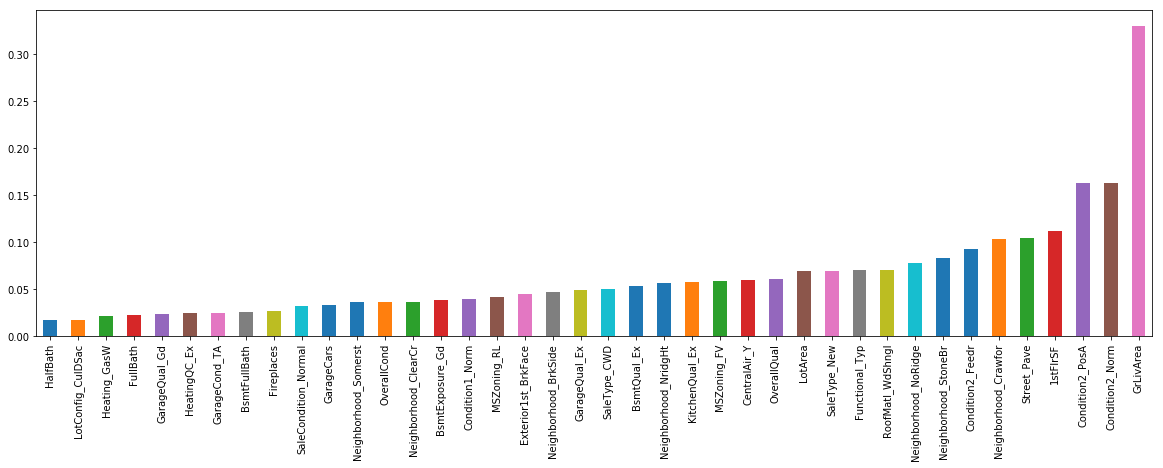

In [45]:
features_imp = pd.Series(index = X_train.columns, data = np.abs(cv_model.coef_))
print('Total important features:',features_imp.shape)
n_selected_features = (features_imp > 0).sum()
print('Selected features: {0:d}, reduction of {1:2.2f}%'.format(n_selected_features,(1 - n_selected_features/ len(features_imp))*100))
features_imp.sort_values().tail(40).plot(kind = 'bar', figsize = (20, 6))

The top 5 features selected are:
* GrLivArea
* RoofMatl_Washngl
* Neighborhood_StoneBr
* Neighborhood_Crawfr
* 1stFlrSF

## XGBoost(with default parameters)

In [46]:
xgb_m1 = XGBRegressor()
xgb_m1.fit(X_train, Y_train)

#Predictions on Train & Test sets
Y_train_pred_xgb1 = xgb_m1.predict(X_train)
Y_test_pred_xgb1 = xgb_m1.predict(X_test)

#r2, mse & rmse scores for xgb_m1
print('XGBoost M1 Stats -->')
print('The r2 train score for XGBoost M1 is: %.2f' %r2_score(Y_train_pred_xgb1, Y_train))
print('The r2 test score for XGBoost M1 is: %.2f' %r2_score(Y_test_pred_xgb1, Y_test))
print('The mse train score for XGBoost M1 is: %.4f' %mean_squared_error(Y_train_pred_xgb1, Y_train))
print('The mse train score for XGBoost M1 is: %.4f' %mean_squared_error(Y_test_pred_xgb1, Y_test))
print('The mse train score for XGBoost M1 is: %.4f' %np.sqrt(mean_squared_error(Y_train_pred_xgb1, Y_train)))
print('The mse train score for XGBoost M1 is: %.4f' %np.sqrt(mean_squared_error(Y_test_pred_xgb1, Y_test)))

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBoost M1 Stats -->
The r2 train score for XGBoost M1 is: 0.95
The r2 test score for XGBoost M1 is: 0.88
The mse train score for XGBoost M1 is: 0.0067
The mse train score for XGBoost M1 is: 0.0173
The mse train score for XGBoost M1 is: 0.0820
The mse train score for XGBoost M1 is: 0.1316


## XGBoost(with few parameters added to improve accuracy)

In [47]:
xgb_m2 = XGBRegressor(n_estimators = 1000)
xgb_m2.fit(X_train, Y_train, early_stopping_rounds = 5, eval_set = [(X_test, Y_test)], verbose = False)

#Predictions on Train & Test sets
Y_train_pred_xgb2 = xgb_m2.predict(X_train)
Y_test_pred_xgb2 = xgb_m2.predict(X_test)

#r2, mse & rmse scores for xgb_m2
print('XGBoost M2 Stats -->')
print('The r2 train score for XGBoost M2 is: %.2f' %r2_score(Y_train_pred_xgb2, Y_train))
print('The r2 test score for XGBoost M2 is: %.2f' %r2_score(Y_test_pred_xgb2, Y_test))
print('The mse train score for XGBoost M2 is: %.4f' %mean_squared_error(Y_train_pred_xgb2, Y_train))
print('The mse test score for XGBoost M2 is: %.4f' %mean_squared_error(Y_test_pred_xgb2, Y_test))
print('The rmse train score for XGBoost M2 is: %.4f' %np.sqrt(mean_squared_error(Y_train_pred_xgb2, Y_train)))
print('The rmse test score for XGBoost M2 is: %.4f' %np.sqrt(mean_squared_error(Y_test_pred_xgb2, Y_test)))

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBoost M2 Stats -->
The r2 train score for XGBoost M2 is: 0.97
The r2 test score for XGBoost M2 is: 0.89
The mse train score for XGBoost M2 is: 0.0049
The mse test score for XGBoost M2 is: 0.0162
The rmse train score for XGBoost M2 is: 0.0699
The rmse test score for XGBoost M2 is: 0.1272


## XGBoost(with learning_rate introduced on top of the additional parameters from the previous model)

In [48]:
xgb_m3 = XGBRegressor(n_estimators = 2000, learning_rate = 0.5)
xgb_m3.fit(X_train, Y_train, early_stopping_rounds = 5, eval_set = [(X_test, Y_test)], verbose = False)

#Predictions on Train & Test sets
Y_train_pred_xgb3 = xgb_m3.predict(X_train)
Y_test_pred_xgb3 = xgb_m3.predict(X_test)

#r2, mse & rmse scores for xgb_m3
print('XGBoost M3 Stats -->')
print('The r2 train score for XGBoost M3 is: %.2f' %r2_score(Y_train_pred_xgb3, Y_train))
print('The r2 test score for XGBoost M3 is: %.2f' %r2_score(Y_test_pred_xgb3, Y_test))
print('The mse train score for XGBoost M3 is: %.4f' %mean_squared_error(Y_train_pred_xgb3, Y_train))
print('The mse test score for XGBoost M3 is: %.4f' %mean_squared_error(Y_test_pred_xgb3, Y_test))
print('The rmse train score for XGBoost M3 is: %.4f' %np.sqrt(mean_squared_error(Y_train_pred_xgb3, Y_train)))
print('The rmse test score for XGBoost M3 is: %.4f' %np.sqrt(mean_squared_error(Y_test_pred_xgb3, Y_test)))

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBoost M3 Stats -->
The r2 train score for XGBoost M3 is: 0.95
The r2 test score for XGBoost M3 is: 0.85
The mse train score for XGBoost M3 is: 0.0076
The mse test score for XGBoost M3 is: 0.0230
The rmse train score for XGBoost M3 is: 0.0872
The rmse test score for XGBoost M3 is: 0.1517


Woah, so M3 gives us slightly poor results compared to that of M2. So we well stick to our M2 model.

Let us try Feature Importance for the XGBoost M2 model. 

In [49]:
from collections import OrderedDict
OrderedDict(sorted(xgb_m2.get_booster().get_fscore().items(), key = lambda x: x[1], reverse = True))

OrderedDict([('LotArea', 68),
             ('GrLivArea', 64),
             ('OverallQual', 56),
             ('TotalBsmtSF', 45),
             ('OverallCond', 45),
             ('GarageYrBlt', 33),
             ('BsmtUnfSF', 30),
             ('LotFrontage', 29),
             ('YearRemodAdd', 27),
             ('BsmtFinSF1', 26),
             ('YearBuilt', 24),
             ('MSSubClass', 24),
             ('GarageArea', 23),
             ('MoSold', 20),
             ('2ndFlrSF', 19),
             ('1stFlrSF', 18),
             ('OpenPorchSF', 17),
             ('MSZoning_C (all)', 16),
             ('EnclosedPorch', 15),
             ('Functional_Typ', 14),
             ('SaleCondition_Abnorml', 13),
             ('Condition1_Norm', 12),
             ('WoodDeckSF', 11),
             ('Neighborhood_Crawfor', 11),
             ('ScreenPorch', 11),
             ('PoolArea', 11),
             ('MasVnrArea', 10),
             ('KitchenAbvGr', 8),
             ('Condition1_Artery', 8),
    

The top 5 features selected are:
* LotArea
* GrLivArea
* OverallQual
* TotalBsmtSF
* OverallCond

**GrLivArea** is the only one selected by both ElasticNetCV and XGBoost regularization techniques. So let us select some relevant features and try and fit the XGBoost algo once more and see our results.

In [50]:
relevant_feats = list(dict((k, v) for k, v in xgb_m2.get_booster().get_fscore().items() if v >= 4).keys())
Xn = data[relevant_feats]
Yn = data['SalePrice']

X_train, X_test, Y_train, Y_test = train_test_split(Xn, Yn, test_size = 0.2, random_state = 0) #Splitting the data with the most relevant features
xgb_m4 = XGBRegressor(n_estimators = 1000) #Creating a new model on the lines of M2
xgb_m4.fit(X_train, Y_train, early_stopping_rounds = 5, eval_set = [(X_test, Y_test)], verbose = False)

#Predictions on Train & Test sets
Y_train_pred_xgb4 = xgb_m4.predict(X_train)
Y_test_pred_xgb4 = xgb_m4.predict(X_test)

#r2, mse & rmse scores for xgb_m4
print('XGBoost M4 Stats -->')
print('The r2 train score for XGBoost M4 is: %.2f' %r2_score(Y_train_pred_xgb4, Y_train))
print('The r2 test score for XGBoost M4 is: %.2f' %r2_score(Y_test_pred_xgb4, Y_test))
print('The mse train score for XGBoost M4 is: %.4f' %mean_squared_error(Y_train_pred_xgb4, Y_train))
print('The mse test score for XGBoost M4 is: %.4f' %mean_squared_error(Y_test_pred_xgb4, Y_test))
print('The rmse train score for XGBoost M4 is: %.4f' %np.sqrt(mean_squared_error(Y_train_pred_xgb4, Y_train)))
print('The rmse test score for XGBoost M4 is: %.4f' %np.sqrt(mean_squared_error(Y_test_pred_xgb4, Y_test)))

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBoost M4 Stats -->
The r2 train score for XGBoost M4 is: 0.96
The r2 test score for XGBoost M4 is: 0.89
The mse train score for XGBoost M4 is: 0.0062
The mse test score for XGBoost M4 is: 0.0159
The rmse train score for XGBoost M4 is: 0.0787
The rmse test score for XGBoost M4 is: 0.1261


That's it! The latest model, the M4, is a slight improvement on our previous models. We end our kernel here. Thank you!

I would sincerely like to thank **Susan Li** who was the inspiration behind this work. Thank you **Susan**!